# Mumbai Indians Power BI Dashboard - Data Preparation

This notebook covers the complete data preparation process:
1. Loading the IPL dataset.
2. Filtering data for Mumbai Indians.
3. Creating the Fact Table (Deliveries).
4. Creating Dimension Tables (Batters, Bowlers, Matches, Seasons, Venues).
5. Creating Summary Tables for quick analysis.

In [ ]:
import pandas as pd
import numpy as np
import os

def save_csv_safe(df, filename):
    """Attempts to save a CSV and catches PermissionError if the file is open."""
    try:
        df.to_csv(filename, index=False)
        print(f"✓ Saved: {filename}")
    except PermissionError:
        print(f"❌ ERROR: Could not save '{filename}'.")
        print("   DETAILS: The file is currently open in another program (Excel/Power BI).")
        print("   ACTION: Please close the file and try running this cell again.")

# Load dataset
input_file = "IPL.csv"
if not os.path.exists(input_file):
    print(f"Error: {input_file} not found.")
else:
    print(f"Loading {input_file}...")
    df = pd.read_csv(input_file)
    
    # --- DATA CLEANING FIX ---
    # Convert '2007/08' to '2008' to avoid plotting errors
    if "season" in df.columns:
        print("Cleaning 'season' column...")
        df["season"] = df["season"].astype(str).replace("2007/08", "2008")
    
    print("Data loaded successfully.")

In [ ]:
TEAM_NAME = "Mumbai Indians"

print(f"Filtering for {TEAM_NAME}...")
# Filter MI batting deliveries
mi_batting = df[df["batting_team"] == TEAM_NAME].copy()

# Filter MI bowling deliveries
mi_bowling = df[df["bowling_team"] == TEAM_NAME].copy()

# Filter all MI involvement (batting or bowling)
mi_all = df[(df["batting_team"] == TEAM_NAME) | (df["bowling_team"] == TEAM_NAME)].copy()
print("Data filtered.")

### Step 2: Create Master Fact Table (Deliveries)

In [ ]:
# Keep all required columns
cols = [
    "match_id", "date", "match_type", "event_name", "innings", "batting_team",
    "bowling_team", "over", "ball", "ball_no", "batter", "bat_pos", "runs_batter",
    "balls_faced", "bowler", "valid_ball", "runs_extras", "runs_total",
    "runs_bowler", "runs_not_boundary", "extra_type", "non_striker",
    "non_striker_pos", "wicket_kind", "player_out", "fielders", "runs_target",
    "review_batter", "team_reviewed", "review_decision", "umpire",
    "umpires_call", "player_of_match", "match_won_by", "win_outcome",
    "toss_winner", "toss_decision", "venue", "city", "day", "month", "year",
    "season", "gender", "team_type", "superover_winner", "result_type",
    "method", "balls_per_over", "overs", "event_match_no", "stage",
    "match_number", "team_runs", "team_balls", "team_wicket", "new_batter",
    "batter_runs", "batter_balls", "bowler_wicket", "batting_partners",
    "next_batter", "striker_out"
]

# Ensure cols exist in df
existing_cols = [c for c in cols if c in mi_batting.columns]
mi_batting_clean = mi_batting[existing_cols].copy()

# Add calculated fields
mi_batting_clean["is_boundary"] = mi_batting_clean["runs_batter"].isin([4, 6]).astype(int)
mi_batting_clean["is_dot"] = (mi_batting_clean["runs_total"] == 0).astype(int)
mi_batting_clean["is_wicket"] = mi_batting_clean["wicket_kind"].notna().astype(int)

# Phase classification
def phase_from_over(o):
    if o <= 6:
        return "Powerplay (1-6)"
    elif o <= 15:
        return "Middle (7-15)"
    else:
        return "Death (16-20)"

if "over" in mi_batting_clean.columns:
    mi_batting_clean["phase"] = mi_batting_clean["over"].apply(phase_from_over)

# Save fact table
save_csv_safe(mi_batting_clean, "MI_Fact_Deliveries.csv")

### Step 3: Create Dimension Tables (Batters & Bowlers)

In [ ]:
# Batter dimension
batter_dim = (
    mi_batting_clean.groupby("batter")
    .agg(
        runs=("runs_batter", "sum"),
        balls=("balls_faced", "sum"),
        innings=("match_id", "nunique"),
        boundaries=("is_boundary", "sum"),
        dots=("is_dot", "sum")
    )
    .reset_index()
)

batter_dim = batter_dim[batter_dim["balls"] > 0]
batter_dim["strike_rate"] = batter_dim["runs"] * 100 / batter_dim["balls"]
batter_dim["boundary_pct"] = batter_dim["boundaries"] * 100 / batter_dim["balls"]
batter_dim["batter_id"] = range(1, len(batter_dim) + 1)

# Fix: Ensure all columns needed for plotting are kept
batter_cols = ["batter_id", "batter", "runs", "balls", "strike_rate", "boundary_pct", "innings", "boundaries", "dots"]
batter_dim = batter_dim[[c for c in batter_cols if c in batter_dim.columns]]

save_csv_safe(batter_dim, "MI_Dim_Batters.csv")

# Bowler Dimension
bowler_dim = (
    mi_bowling.groupby("bowler")
    .agg(
        runs_conceded=("runs_total", "sum"),
        balls_bowled=("valid_ball", "sum"),
        wickets=("bowler_wicket", "sum"),
        matches=("match_id", "nunique")
    )
    .reset_index()
)

bowler_dim = bowler_dim[bowler_dim["balls_bowled"] >= 120]
bowler_dim["overs"] = bowler_dim["balls_bowled"] / 6
bowler_dim["economy"] = bowler_dim["runs_conceded"] / bowler_dim["overs"]
bowler_dim["strike_rate"] = bowler_dim["balls_bowled"] / bowler_dim["wickets"].replace(0, np.nan)
bowler_dim["bowler_id"] = range(1, len(bowler_dim) + 1)

# Fix: Added 'matches' to the list of kept columns so it can be used in the scatter plot size
bowler_cols = ["bowler_id", "bowler", "wickets", "economy", "strike_rate", "overs", "runs_conceded", "matches"]
bowler_dim = bowler_dim[[c for c in bowler_cols if c in bowler_dim.columns]]

save_csv_safe(bowler_dim, "MI_Dim_Bowlers.csv")

### Step 4: Create Other Dimension Tables (Matches, Seasons, Venues)

In [ ]:
# Match Dimension
match_cols_agg = {
    "match_type": "first",
    "toss_winner": "first",
    "match_won_by": "first",
    "result_type": "first"
}
match_groupby_cols = ["match_id", "season", "match_number", "venue", "city", "date"]
match_groupby_cols = [c for c in match_groupby_cols if c in mi_all.columns]
existing_agg_cols = {k: v for k, v in match_cols_agg.items() if k in mi_all.columns}

agg_dict = {}
for k, v in existing_agg_cols.items():
    agg_dict[k] = (k, v)

match_dim = mi_all.groupby(match_groupby_cols).agg(**agg_dict).reset_index()
match_dim["match_id_key"] = range(1, len(match_dim) + 1)
match_dim_cols = ["match_id_key"] + match_groupby_cols + list(existing_agg_cols.keys())
match_dim = match_dim[match_dim_cols]
save_csv_safe(match_dim, "MI_Dim_Matches.csv")

# Season Dimension
if "season" in mi_all.columns:
    season_dim = (
        mi_all[["season"]]
        .drop_duplicates()
        .sort_values("season", key=lambda x: x.astype(str))
        .reset_index(drop=True)
    )
    season_dim["season_id"] = range(1, len(season_dim) + 1)
    season_dim = season_dim[["season_id", "season"]]
    save_csv_safe(season_dim, "MI_Dim_Seasons.csv")

# Venue Dimension
venue_cols = ["venue", "city"]
venue_cols = [c for c in venue_cols if c in mi_all.columns]
venue_dim = (
    mi_all[venue_cols]
    .drop_duplicates()
    .reset_index(drop=True)
)
venue_dim["venue_id"] = range(1, len(venue_dim) + 1)
venue_dim = venue_dim[["venue_id"] + venue_cols]
save_csv_safe(venue_dim, "MI_Dim_Venues.csv")

### Step 5: Summary Tables

In [ ]:
# Season-wise batting summary
if "season" in mi_batting_clean.columns:
    season_batting = (
        mi_batting_clean.groupby("season")
        .agg(
            runs_scored=("runs_total", "sum"),
            balls_faced=("valid_ball", "sum"),
            matches=("match_id", "nunique"),
            boundaries=("is_boundary", "sum"),
            wickets=("is_wicket", "sum")
        )
        .reset_index()
    )
    season_batting["run_rate"] = season_batting["runs_scored"] * 6 / season_batting["balls_faced"]
    save_csv_safe(season_batting, "MI_Summary_Season_Batting.csv")

# Venue-wise stats
if "venue" in mi_batting_clean.columns:
    venue_stats = (
        mi_batting_clean.groupby("venue")
        .agg(
            runs=("runs_total", "sum"),
            balls=("valid_ball", "sum"),
            matches=("match_id", "nunique")
        )
        .reset_index()
    )
    venue_stats["run_rate"] = venue_stats["runs"] * 6 / venue_stats["balls"]
    venue_stats = venue_stats[venue_stats["matches"] >= 3]
    save_csv_safe(venue_stats, "MI_Summary_Venue_Stats.csv")

# Phase-wise stats
if "phase" in mi_batting_clean.columns:
    phase_stats = (
        mi_batting_clean.groupby("phase")
        .agg(
            runs=("runs_total", "sum"),
            balls=("valid_ball", "sum")
        )
        .reset_index()
    )
    phase_stats["run_rate"] = phase_stats["runs"] * 6 / phase_stats["balls"]
    save_csv_safe(phase_stats, "MI_Summary_Phase_Stats.csv")

# Visual Analytics & Insights

Below are high-quality visualizations to derive insights about Mumbai Indians' performance.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Style
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# Force season to string in case it isn't already, for plotting
season_batting["season"] = season_batting["season"].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=season_batting, x="season", y="runs_scored", marker="o", linewidth=2.5, color="#004BA0")
plt.title("Total Runs Scored Per Season", fontsize=16, fontweight="bold", color="#004BA0")
plt.xlabel("Season", fontsize=12)
plt.ylabel("Runs Scored", fontsize=12)
plt.xticks(rotation=45)
plt.show()

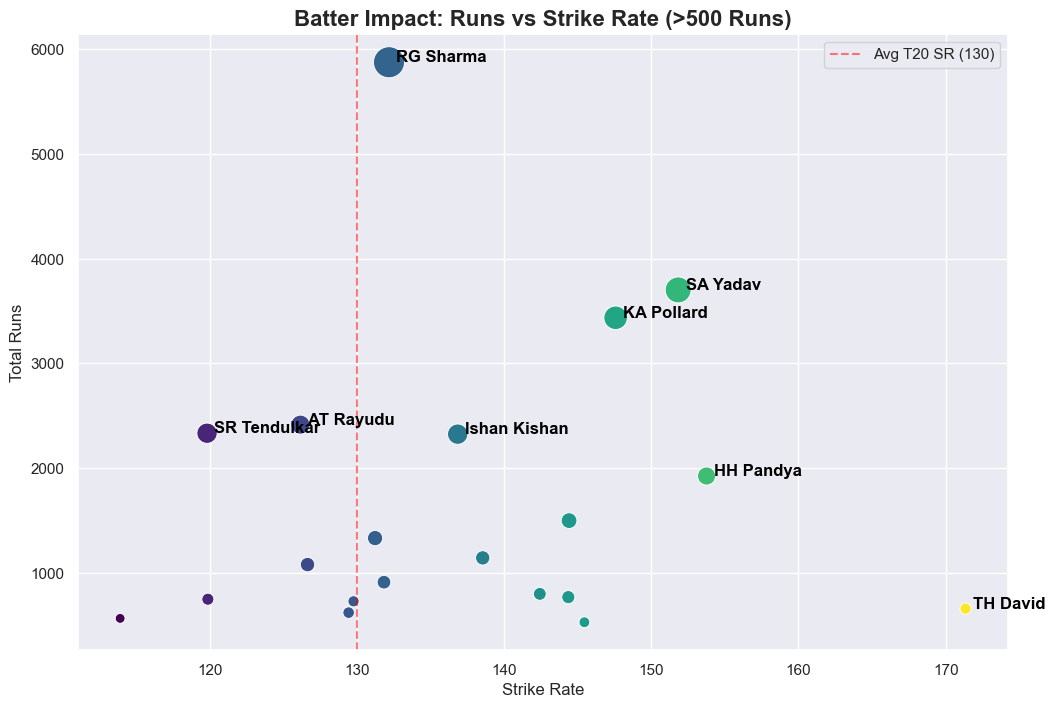

In [24]:
key_batters = batter_dim[batter_dim["runs"] > 500].copy()

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=key_batters, 
    x="strike_rate", 
    y="runs", 
    size="boundaries", 
    sizes=(50, 500), 
    hue="strike_rate",
    palette="viridis",
    legend=False
)

# Annotate top players
for line in range(0, key_batters.shape[0]):
    if key_batters.iloc[line]["runs"] > 1500 or key_batters.iloc[line]["strike_rate"] > 150:
        scatter.text(
            key_batters.strike_rate.iloc[line]+0.5, 
            key_batters.runs.iloc[line], 
            key_batters.batter.iloc[line], 
            horizontalalignment='left', 
            size='medium', 
            color='black', 
            weight='semibold'
        )

plt.title("Batter Impact: Runs vs Strike Rate (>500 Runs)", fontsize=16, fontweight="bold")
plt.xlabel("Strike Rate", fontsize=12)
plt.ylabel("Total Runs", fontsize=12)
plt.axvline(x=130, color='red', linestyle='--', alpha=0.5, label="Avg T20 SR (130)")
plt.legend()
plt.show()

⚠️ Warning: 'matches' column missing in bowler_dim. Plotting with constant size.
  (Re-run Step 3 cells to fix this permanently)


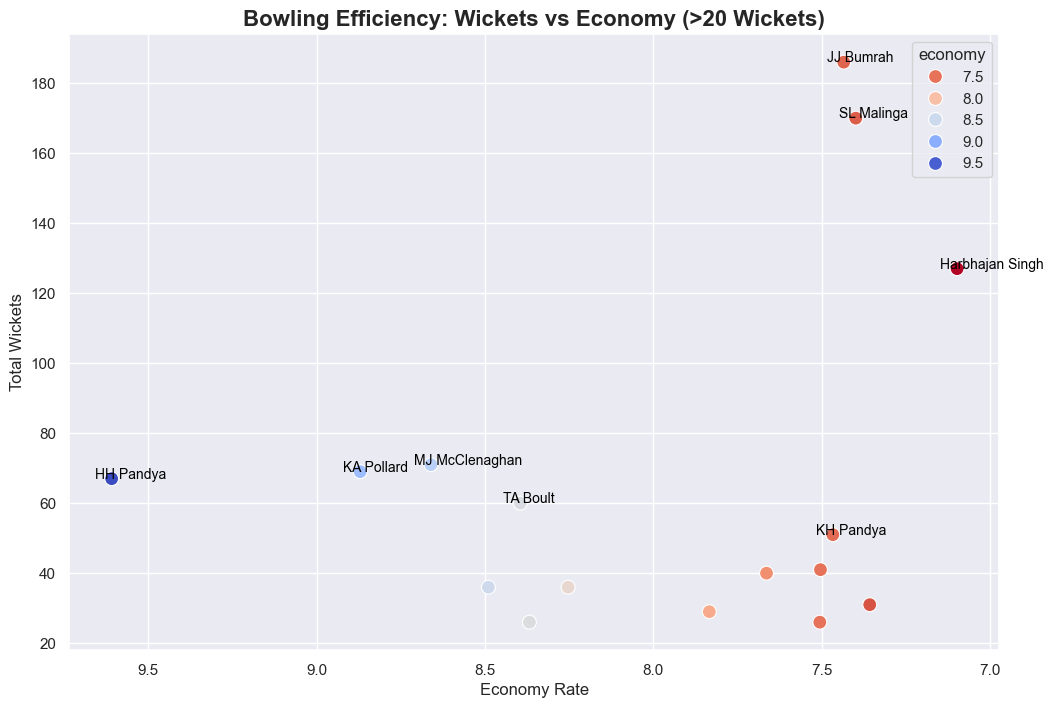

In [25]:
key_bowlers = bowler_dim[bowler_dim["wickets"] > 20].copy()

# --- SAFE PLOTTING CHECK ---
# Determine size variable based on available columns
if "matches" in key_bowlers.columns:
    size_var = "matches"
    sizes_range = (50, 400)
else:
    # Fallback if 'matches' is missing
    print("⚠️ Warning: 'matches' column missing in bowler_dim. Plotting with constant size.")
    print("  (Re-run Step 3 cells to fix this permanently)")
    size_var = None
    sizes_range = None

plt.figure(figsize=(12, 8))
if size_var:
    sns.scatterplot(
        data=key_bowlers, 
        x="economy", 
        y="wickets", 
        size=size_var, 
        sizes=sizes_range, 
        hue="economy",
        palette="coolwarm_r"
    )
else:
    # CONSTANT SIZE PLOT
    sns.scatterplot(
        data=key_bowlers, 
        x="economy", 
        y="wickets", 
        s=100, # constant size
        hue="economy",
        palette="coolwarm_r"
    )

# Annotate top bowlers
for line in range(0, key_bowlers.shape[0]):
    if key_bowlers.iloc[line]["wickets"] > 50 or key_bowlers.iloc[line]["economy"] < 7.0:
        plt.text(
            key_bowlers.economy.iloc[line]+0.05, 
            key_bowlers.wickets.iloc[line], 
            key_bowlers.bowler.iloc[line], 
            horizontalalignment='left', 
            size='small', 
            color='black'
        )

plt.title("Bowling Efficiency: Wickets vs Economy (>20 Wickets)", fontsize=16, fontweight="bold")
plt.xlabel("Economy Rate", fontsize=12)
plt.ylabel("Total Wickets", fontsize=12)
plt.gca().invert_xaxis() 
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18276\3274639514.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=phase_stats, x="phase", y="run_rate", palette=colors)


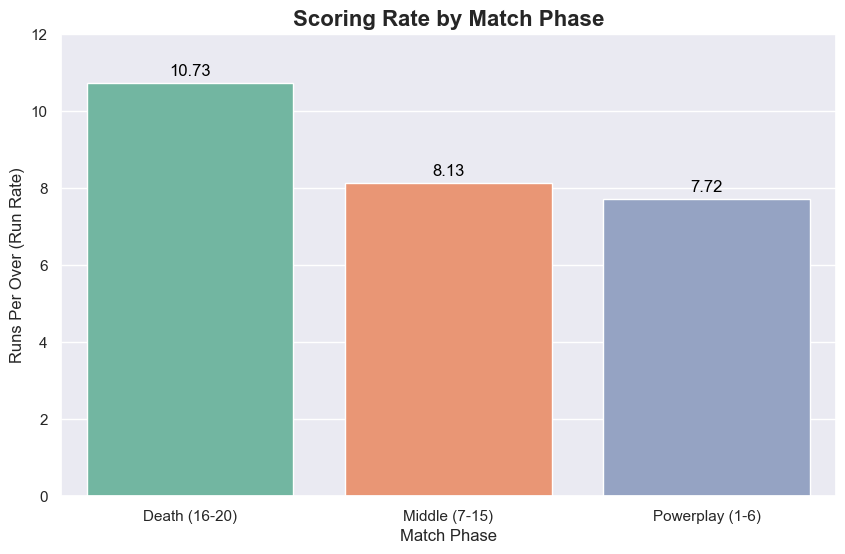

In [26]:
plt.figure(figsize=(10, 6))
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
sns.barplot(data=phase_stats, x="phase", y="run_rate", palette=colors)

plt.title("Scoring Rate by Match Phase", fontsize=16, fontweight="bold")
plt.xlabel("Match Phase", fontsize=12)
plt.ylabel("Runs Per Over (Run Rate)", fontsize=12)
plt.ylim(0, 12)
for index, row in phase_stats.iterrows():
    plt.text(index, row.run_rate + 0.2, f"{row.run_rate:.2f}", color='black', ha="center")

plt.show()